Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/sadegh/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/sadegh/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✅ Found existing file at data/LoDoPaB-CT_small.pt


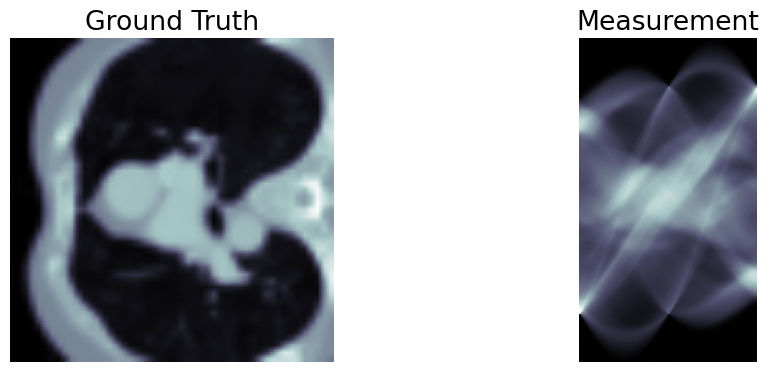

Running reconstruction for CT with DiffPIR...


100%|█████████████████████████████████████████| 500/500 [00:52<00:00,  9.61it/s]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sadegh/miniconda3/envs/deepinv/lib/python3.13/site-packages/lpips/weights/v0.1/alex.pth
Evaluation Results:
DiffPIR - PSNR: 49.8519
DiffPIR - SSIM: 0.9931
DiffPIR - LPIPS: 0.0024
DiffPIR - FID: 249.8022
DDRM - PSNR: 27.8423
DDRM - SSIM: 0.9454
DDRM - LPIPS: 0.1554
DDRM - FID: 320.5361


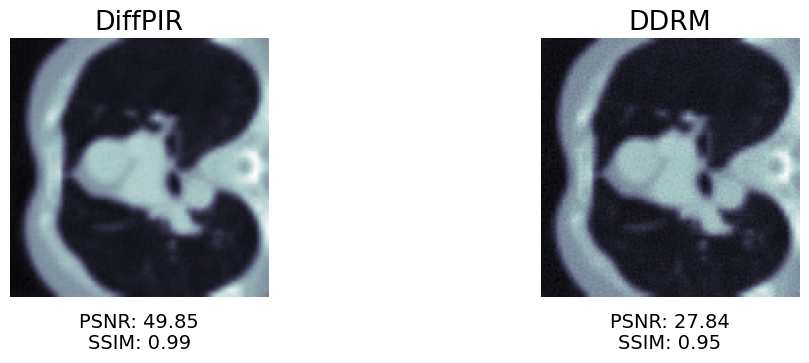

In [7]:
import torch
import numpy as np
from diffusers import DDPMPipeline
import sys, os
# Adding project root (parent of notebooks/) to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
# === Imports from Repo ===
from algorithms.diffpir import diffpir
from algorithms.dps import dps
from algorithms.repaint import repaint
from algorithms.ddrm import ddrm_ddim, ddrm_ddpm
from utils.dataset import get_pipeline_and_dataset
from utils.degrade import degrade_dataloader
from utils.visualization import show_images
from utils.metrics import MetricsEvaluator
import deepinv as dinv
from physics.inpainting import InpaintingProblem

torch.manual_seed(0)

# === Device Selection ===
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)


# === Load Pipeline and Dataset ===
pipeline, dataloader = get_pipeline_and_dataset(
    model_name="google/ddpm-celebahq-256",
    dataset_name="CT",   # options: "CT", "CelebA-HQ", ...
    batch_size=1,
    img_size=128,
    subset_ratio=0.01,
    device=device
)


# === Problem Selection ===
problem = "CT"  # options: "inpainting", "CT", "blur_Gaussian", "blur_motion"
img_size = (3, 128, 128)
noise_level = 0.1

if problem == "inpainting":
    mask = torch.ones(1, img_size[1], img_size[2])
    mask[:, 32:64, 32:64] = 0
    physics = InpaintingProblem(img_size=img_size, mask=mask, device=device)

elif problem == "CT":
    angles = 100
    physics = dinv.physics.Tomography(
        img_width=img_size[1],
        angles=angles,
        circle=False,
        device=device,
    )

elif problem == "blur_Gaussian":
    kernel = dinv.physics.blur.gaussian_blur(sigma=(1.0, 1.0), angle=0.0)
    physics = dinv.physics.Blur(kernel, device=device, padding="replicate")

elif problem == "blur_motion":
    kernel = dinv.physics.blur.gaussian_blur(sigma=(2, 0.1), angle=0.0)
    physics = dinv.physics.Blur(kernel, device=device, padding="replicate")

else:
    raise ValueError(f"Unknown problem type: {problem}")


# === Define Forward and Pseudo-inverse Operators ===
A, A_pinv = physics.A, physics.A_dagger


# === Corrupt Dataset ===
noisy_dataloader = degrade_dataloader(dataloader, A, noise_std=noise_level, device=device)


# === Load One Sample (clean + corrupted) ===
sample_clean = next(iter(dataloader))
clean_img = sample_clean["image"].to(device) if isinstance(sample_clean, dict) else sample_clean[0].to(device)

sample_noisy = next(iter(noisy_dataloader))
y = sample_noisy[0].to(device)

show_images(
    [torch.mean((clean_img + 1) / 2, dim=1, keepdim=True), torch.mean((y + 1) / 2, dim=1, keepdim=True)],
    titles=["Ground Truth", "Measurement"],
    save_path=os.path.join(f"{problem}_gt_corrupted.png"),
    cmap = "bone"
)

with torch.no_grad():
    # === Run DiffPIR ===
    print(f"Running reconstruction for {problem} with DiffPIR...")
    reconstructed_diffpir = diffpir(
        pipeline=pipeline,
        y=y,
        A=A,
        A_pinv=A_pinv,
        sigma_n=noise_level,
        num_inference_steps=100,
    )

    # rescale [-1,1] to [0,1]
    clean_img = (clean_img + 1) / 2
    reconstructed_diffpir = (reconstructed_diffpir + 1) / 2
    y = (y + 1) / 2

    # === Run DDRM ===
    reconstructed_ddrm = ddrm_ddim(
        pipeline=pipeline,
        y=y,
        A=A,
        A_pinv=A_pinv,
        num_inference_steps=500,
    )
    reconstructed_ddrm = (reconstructed_ddrm + 1) / 2
# === Visualization ===
evaluator = MetricsEvaluator(device=device)

results_diffpir = evaluator.compute_all(reconstructed_diffpir, clean_img)
results_ddrm = evaluator.compute_all(reconstructed_ddrm, clean_img)

print("Evaluation Results:")
for k, v in results_diffpir.items():
    print(f"DiffPIR - {k}: {v:.4f}")

for k, v in results_ddrm.items():
    print(f"DDRM - {k}: {v:.4f}")

show_images([torch.mean(reconstructed_diffpir, dim=1, keepdim=True), torch.mean(reconstructed_ddrm, dim=1, keepdim=True)], titles=["DiffPIR", "DDRM"], metrics=[
        {"PSNR": results_diffpir["PSNR"], "SSIM": results_diffpir["SSIM"]},
        {"PSNR": results_ddrm["PSNR"], "SSIM": results_ddrm["SSIM"]}
    ],
            save_path=os.path.join( f"{problem}_reconstructed.png"),
            cmap = "bone"
)
